Block 0 — Install Dependencies

In [1]:
!pip install --quiet shap lightgbm xgboost imbalanced-learn category_encoders optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.8 MB/s eta 0:00:00


Block 1 — Imports & Constants


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE

import category_encoders as ce
import shap
import lightgbm as lgb
import xgboost as xgb

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set(style="whitegrid")

Block 2 — Load Dataset


In [3]:
DATA_PATH = "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Block 3 — Data Cleaning


In [4]:
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype(str).str.strip()

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

service_cols = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for c in service_cols:
    df[c] = df[c].replace({'No internet service': 'No'})
df['MultipleLines'] = df['MultipleLines'].replace({'No phone service': 'No'})
df['SeniorCitizen'] = df['SeniorCitizen'].map({1: 'Yes', 0: 'No'})
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print("Cleaned data sample:")
df.head()

Cleaned data sample:


/tmp/ipython-input-580904544.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,No,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


Block 4 — Exploratory Data Analysis (EDA)


/tmp/ipython-input-1834444021.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Churn', data=df, palette='viridis')


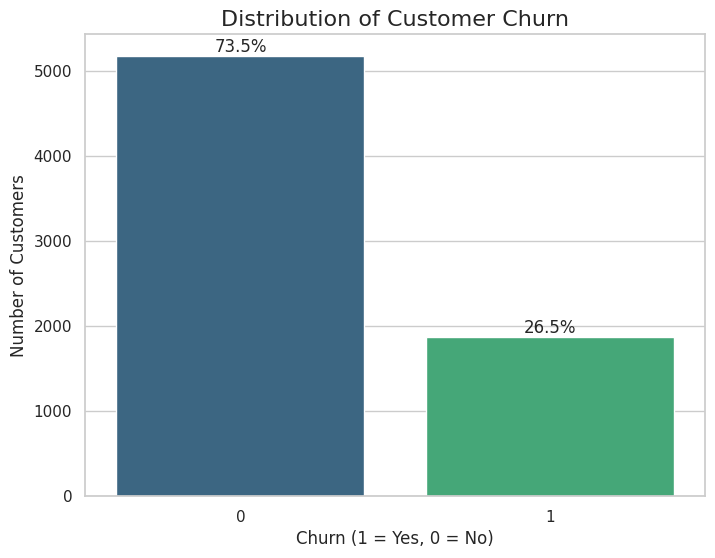

In [5]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Churn', data=df, palette='viridis')
plt.title('Distribution of Customer Churn', fontsize=16)
plt.xlabel('Churn (1 = Yes, 0 = No)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

total = len(df['Churn'])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

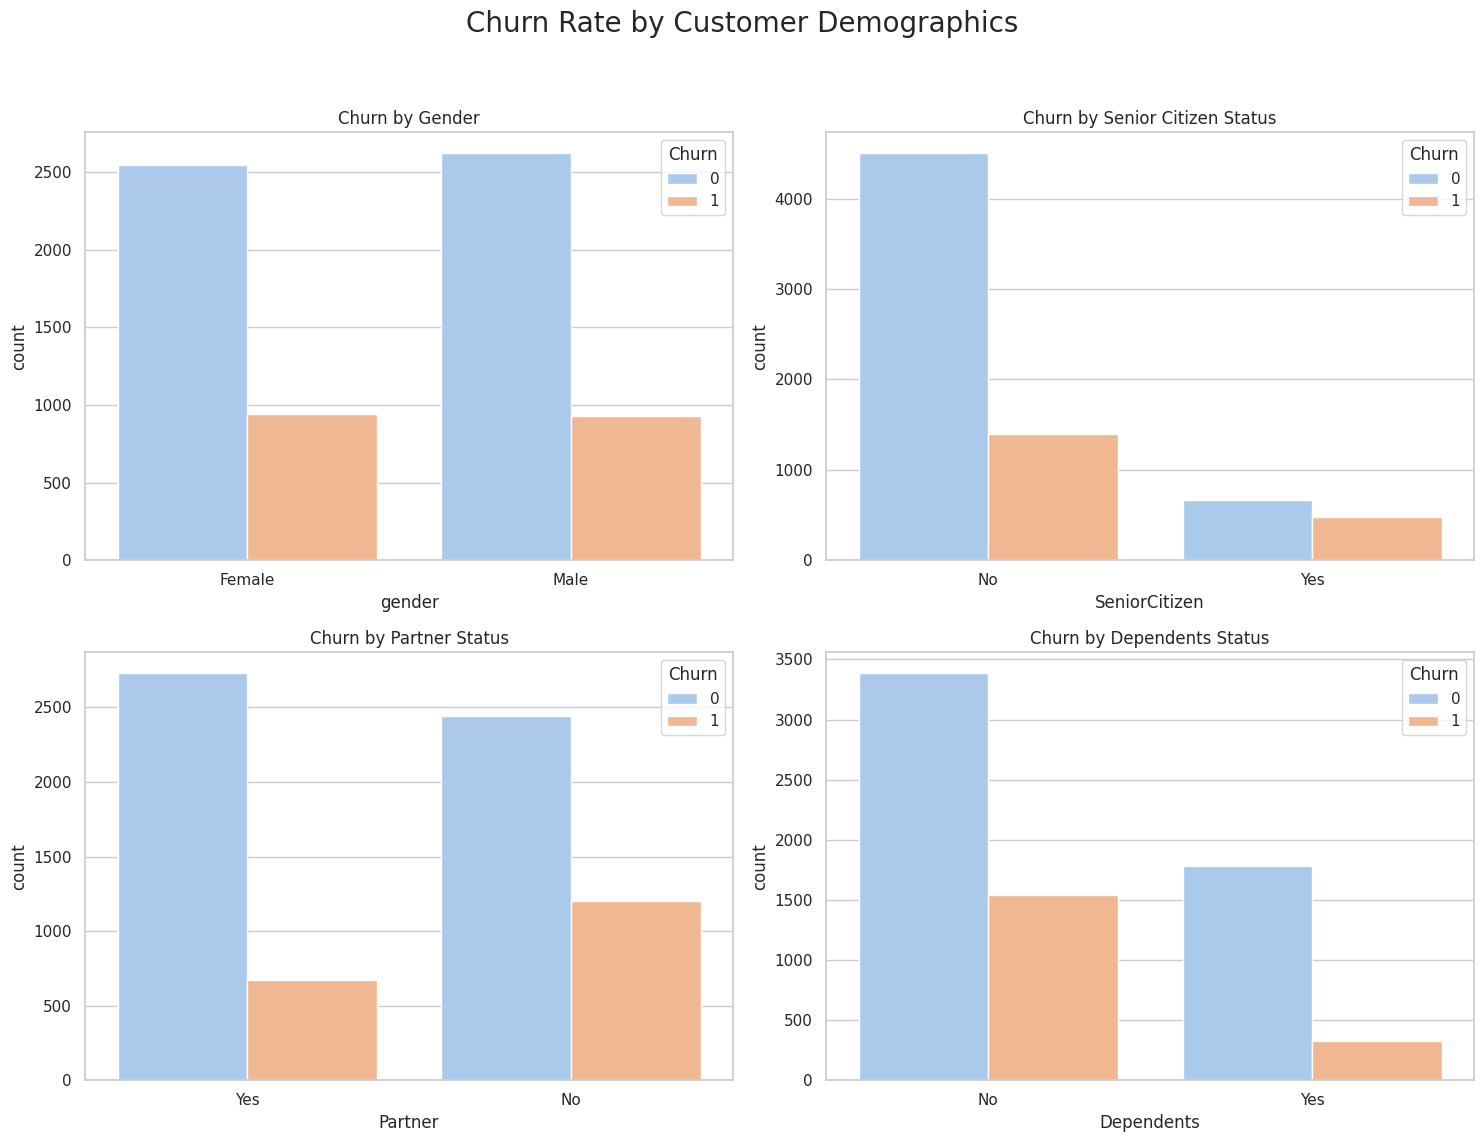

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
fig.suptitle('Churn Rate by Customer Demographics', fontsize=20)

sns.countplot(x='gender', hue='Churn', data=df, ax=axes[0, 0], palette='pastel')
axes[0, 0].set_title('Churn by Gender')

sns.countplot(x='SeniorCitizen', hue='Churn', data=df, ax=axes[0, 1], palette='pastel')
axes[0, 1].set_title('Churn by Senior Citizen Status')

sns.countplot(x='Partner', hue='Churn', data=df, ax=axes[1, 0], palette='pastel')
axes[1, 0].set_title('Churn by Partner Status')

sns.countplot(x='Dependents', hue='Churn', data=df, ax=axes[1, 1], palette='pastel')
axes[1, 1].set_title('Churn by Dependents Status')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

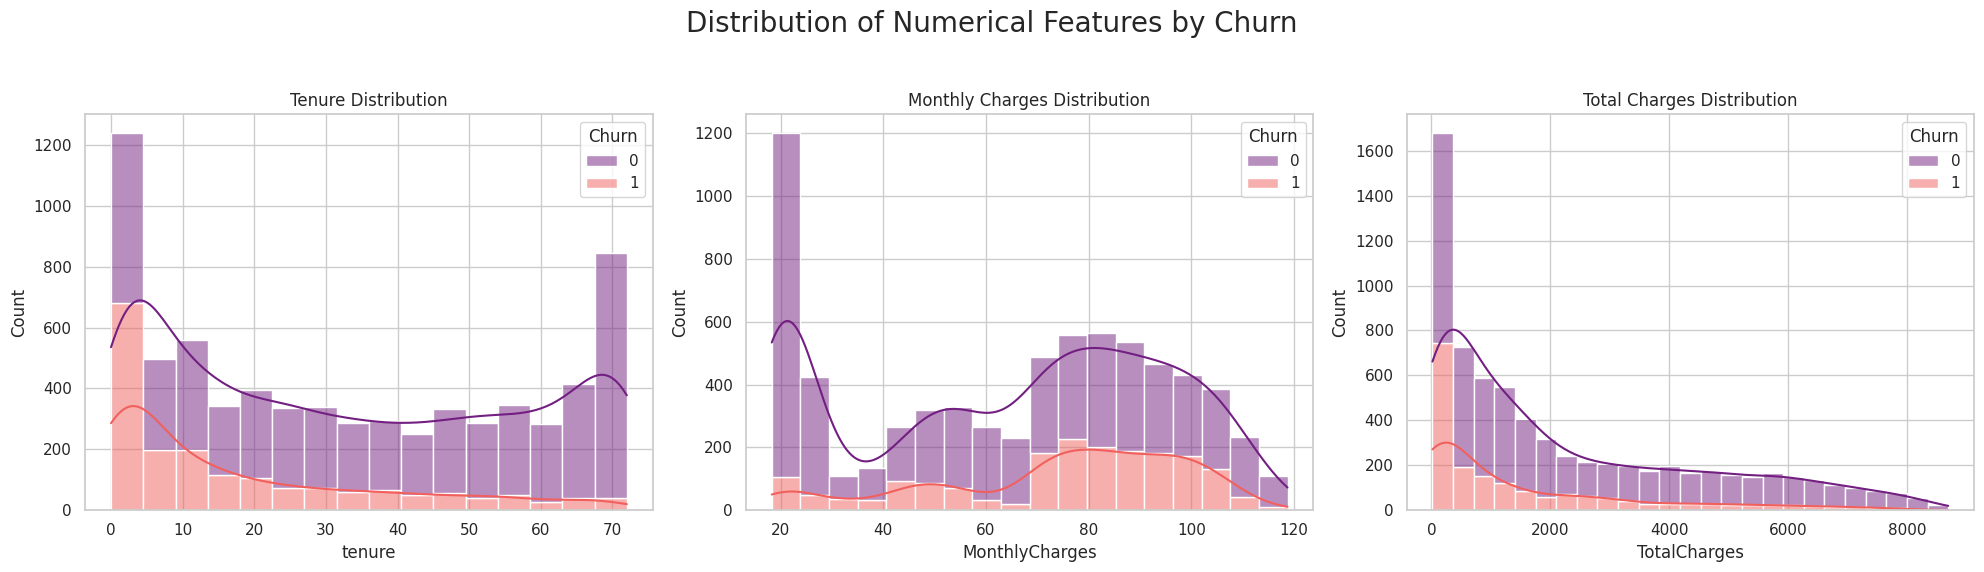

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.suptitle('Distribution of Numerical Features by Churn', fontsize=20)

sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', kde=True, ax=axes[0], palette='magma')
axes[0].set_title('Tenure Distribution')

sns.histplot(data=df, x='MonthlyCharges', hue='Churn', multiple='stack', kde=True, ax=axes[1], palette='magma')
axes[1].set_title('Monthly Charges Distribution')

sns.histplot(data=df, x='TotalCharges', hue='Churn', multiple='stack', kde=True, ax=axes[2], palette='magma')
axes[2].set_title('Total Charges Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

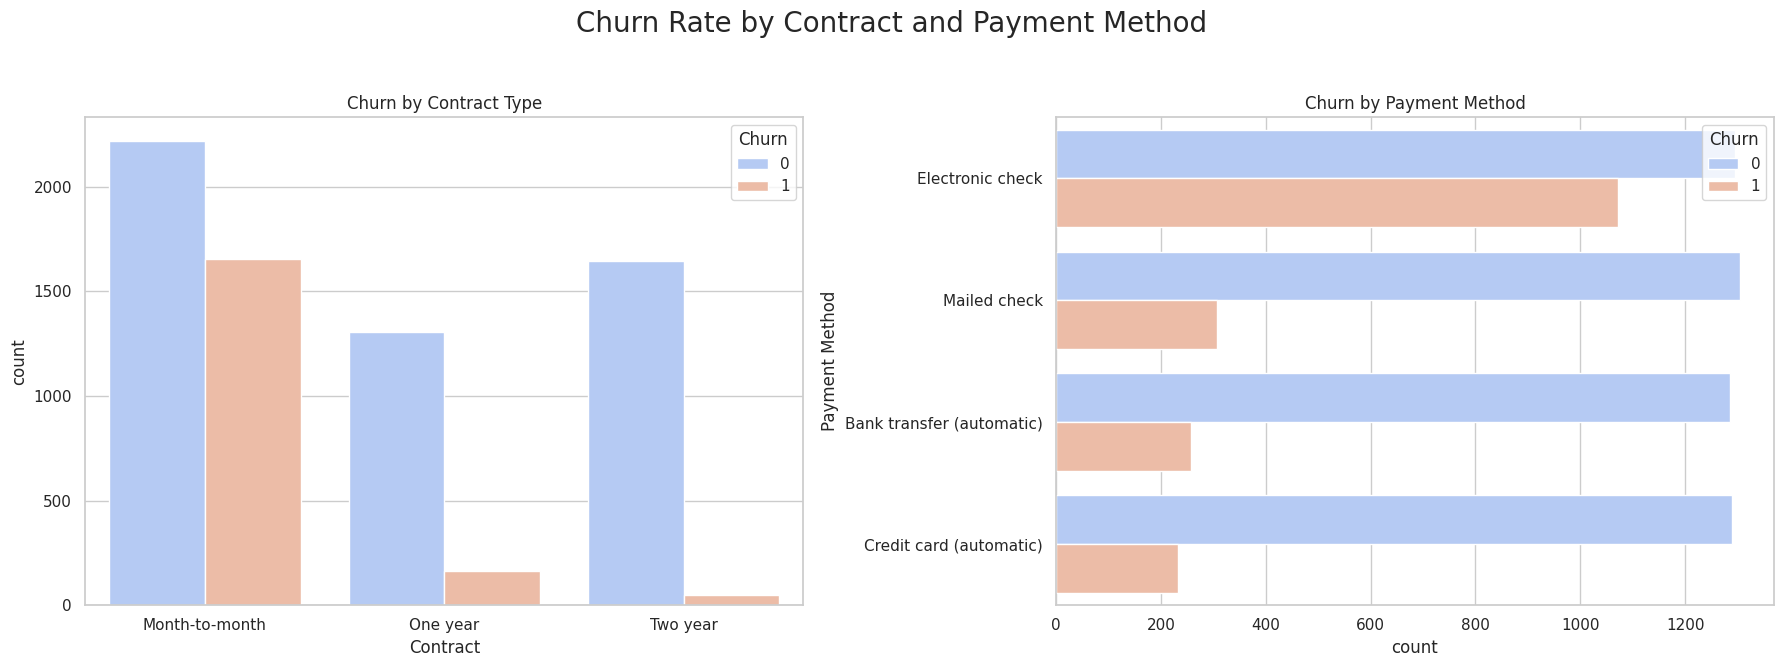

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
fig.suptitle('Churn Rate by Contract and Payment Method', fontsize=20)

sns.countplot(x='Contract', hue='Churn', data=df, ax=axes[0], palette='coolwarm')
axes[0].set_title('Churn by Contract Type')

sns.countplot(y='PaymentMethod', hue='Churn', data=df, ax=axes[1], palette='coolwarm')
axes[1].set_title('Churn by Payment Method')
axes[1].set_ylabel('Payment Method')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Block 5 — Feature Engineering


In [9]:
def add_features(df):
    X = df.copy()
    service_cols = ['PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                    'DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
    X['ServicesCount'] = (X[service_cols] == 'Yes').sum(axis=1)
    X['ContractOrd'] = X['Contract'].map({'Month-to-month':0,'One year':1,'Two year':2})
    X['IsAutoPay'] = X['PaymentMethod'].str.contains('automatic', case=False, na=False).astype(int)
    X['SimpleCLV'] = X['MonthlyCharges'] * X['tenure']
    X['HasInternet'] = (X['InternetService'] != 'No').astype(int)
    return X

Xfull = add_features(df)
Xfull.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ServicesCount,ContractOrd,IsAutoPay,SimpleCLV,HasInternet
0,7590-VHVEG,Female,No,Yes,No,1,No,No,DSL,No,...,Yes,Electronic check,29.85,29.85,0,1,0,0,29.85,1
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,Mailed check,56.95,1889.50,0,3,1,0,1936.30,1
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,Yes,Mailed check,53.85,108.15,1,3,0,0,107.70,1
3,7795-CFOCW,Male,No,No,No,45,No,No,DSL,Yes,...,No,Bank transfer (automatic),42.30,1840.75,0,3,1,1,1903.50,1
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,Yes,Electronic check,70.70,151.65,1,1,0,0,141.40,1


Block 6 — Prepare Data


In [10]:
y = Xfull['Churn']
X = Xfull.drop(columns=['Churn', 'customerID'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

Block 7 — Preprocessing Pipeline


In [11]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', ce.TargetEncoder())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

Block 8 — Apply Preprocessing & SMOTE


In [12]:
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_imputer = SimpleImputer(strategy='median')
num_scaler = StandardScaler()

X_train_num = num_imputer.fit_transform(X_train[num_cols])
X_test_num = num_imputer.transform(X_test[num_cols])
X_train_num = num_scaler.fit_transform(X_train_num)
X_test_num = num_scaler.transform(X_test_num)

target_encoder = TargetEncoder(cols=cat_cols)
X_train_cat = target_encoder.fit_transform(X_train[cat_cols], y_train)
X_test_cat = target_encoder.transform(X_test[cat_cols])

X_train_proc = np.hstack([X_train_num, X_train_cat])
X_test_proc = np.hstack([X_test_num, X_test_cat])

smote = SMOTE(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = smote.fit_resample(X_train_proc, y_train)

print(f"Preprocessing completed. Balanced training shape: {X_train_bal.shape}")

Preprocessing completed. Balanced training shape: (8278, 24)


Block 9 — Train Models & Select Best (Enhanced)


In [13]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE, n_jobs=-1),
    "LightGBM": lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)
}

fitted_models = {}
roc_aucs = {}
predictions = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test_proc)
    y_proba = model.predict_proba(X_test_proc)[:,1]

    roc_auc_value = roc_auc_score(y_test, y_proba)

    print(f"ROC-AUC: {roc_auc_value:.4f}")

    fitted_models[name] = model
    roc_aucs[name] = roc_auc_value
    predictions[name] = {'pred': y_pred, 'proba': y_proba}

best_model_name = max(roc_aucs, key=roc_aucs.get)
best_model = fitted_models[best_model_name]
print(f"\n Best Model: {best_model_name} with ROC-AUC: {roc_aucs[best_model_name]:.4f}\n")


--- Training LogisticRegression ---
ROC-AUC: 0.8408

--- Training RandomForest ---
ROC-AUC: 0.8275

--- Training XGBoost ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:13:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC-AUC: 0.8204

--- Training LightGBM ---
[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4522
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ROC-AUC: 0.8329

 Best Model: LogisticRegression with ROC-AUC: 0.8408



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


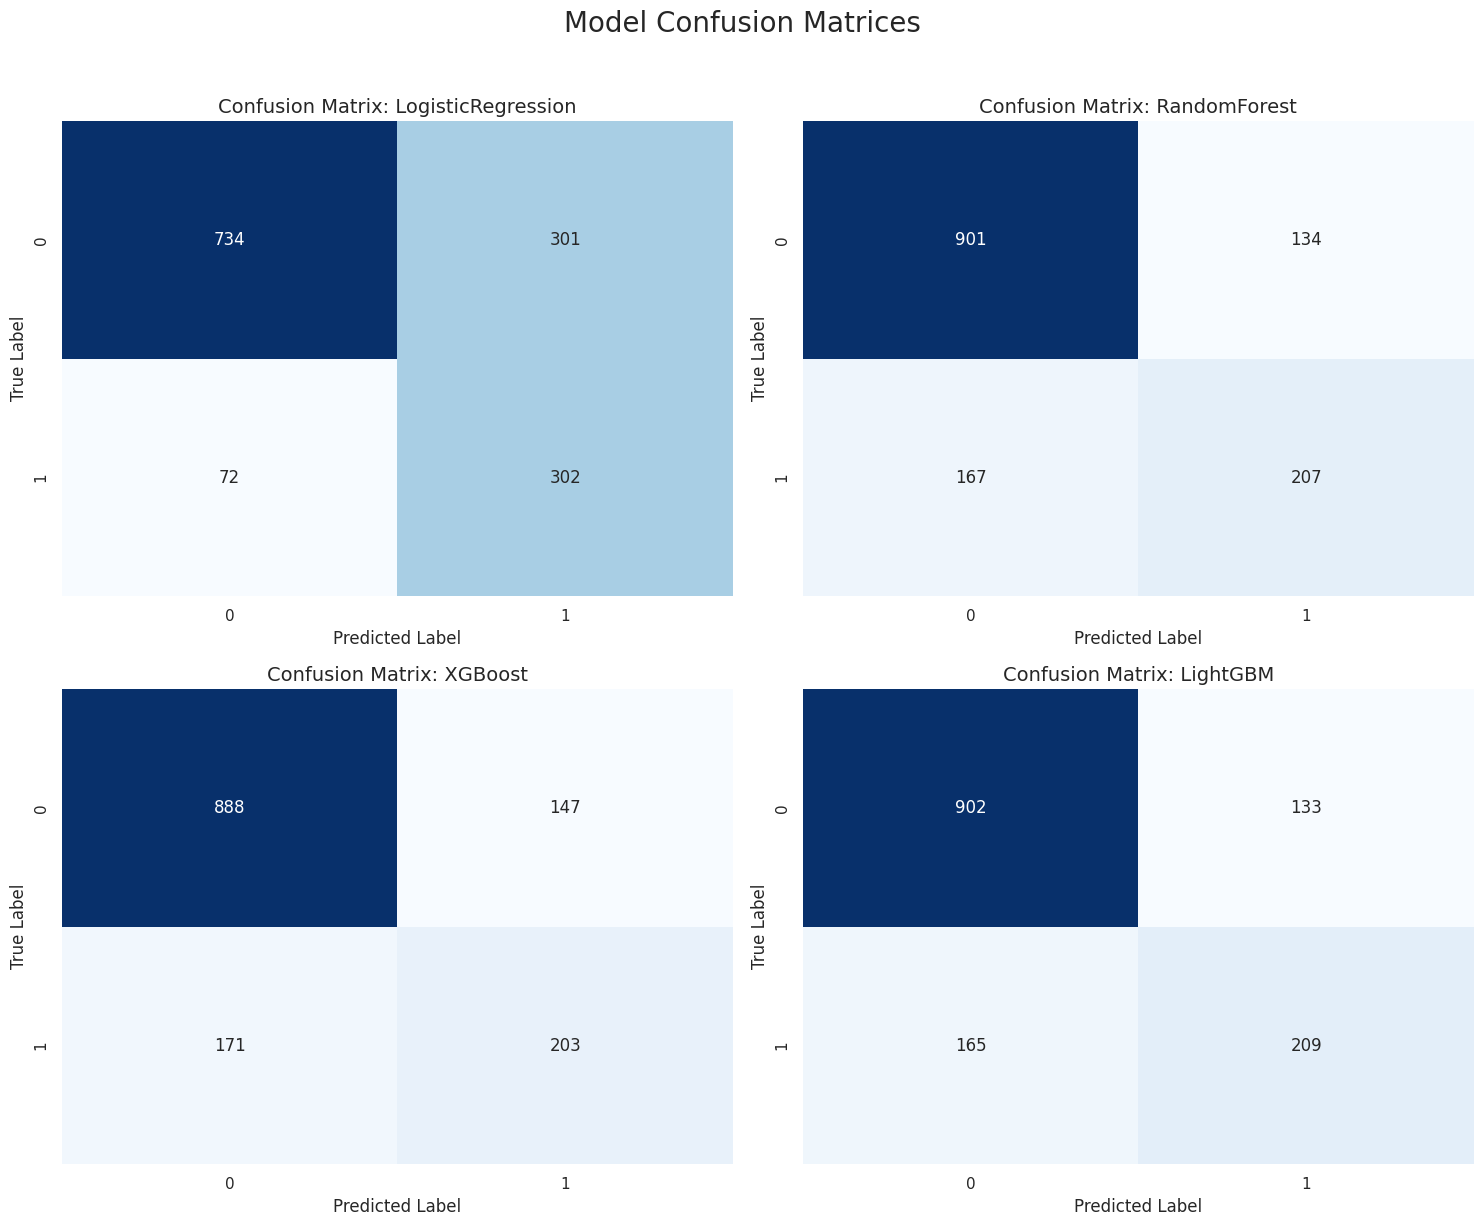


Classification Reports

--- LogisticRegression ---
              precision    recall  f1-score   support

        Stay       0.91      0.71      0.80      1035
       Churn       0.50      0.81      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409


--- RandomForest ---
              precision    recall  f1-score   support

        Stay       0.84      0.87      0.86      1035
       Churn       0.61      0.55      0.58       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.78      1409


--- XGBoost ---
              precision    recall  f1-score   support

        Stay       0.84      0.86      0.85      1035
       Churn       0.58      0.54      0.56       374

    accuracy                           0.77      1409
   macro avg       0.71      0.70    

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
axes = axes.flatten()

for i, (name, model) in enumerate(fitted_models.items()):
    ax = axes[i]
    y_pred = predictions[name]['pred']
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'Confusion Matrix: {name}', fontsize=14)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

fig.suptitle('Model Confusion Matrices', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("Classification Reports")
print("="*50)
for name in fitted_models:
    print(f"\n--- {name} ---")
    print(classification_report(y_test, predictions[name]['pred'], target_names=['Stay', 'Churn']))

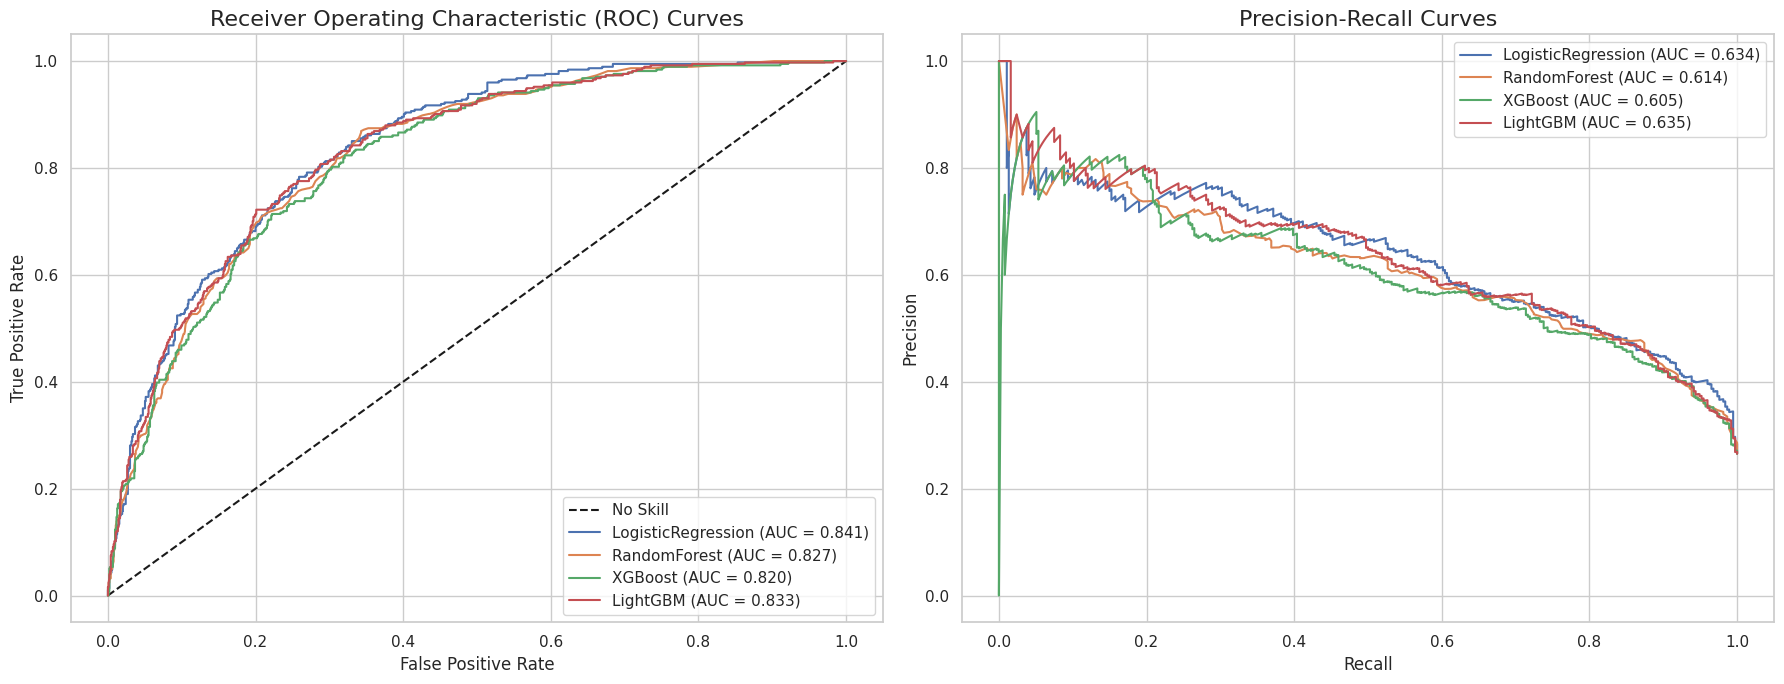

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

ax1.plot([0, 1], [0, 1], 'k--', label='No Skill')
for name, results in predictions.items():
    fpr, tpr, _ = roc_curve(y_test, results['proba'])
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
ax1.set_title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend()

for name, results in predictions.items():
    precision, recall, _ = precision_recall_curve(y_test, results['proba'])
    pr_auc = auc(recall, precision)
    ax2.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})')
ax2.set_title('Precision-Recall Curves', fontsize=16)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend()

plt.tight_layout()
plt.show()

Block 10 — SHAP Global Explanation



 SHAP Global Explanation


/tmp/ipython-input-4268623928.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test_proc[:200], feature_names=all_cols, max_display=10, show=True)


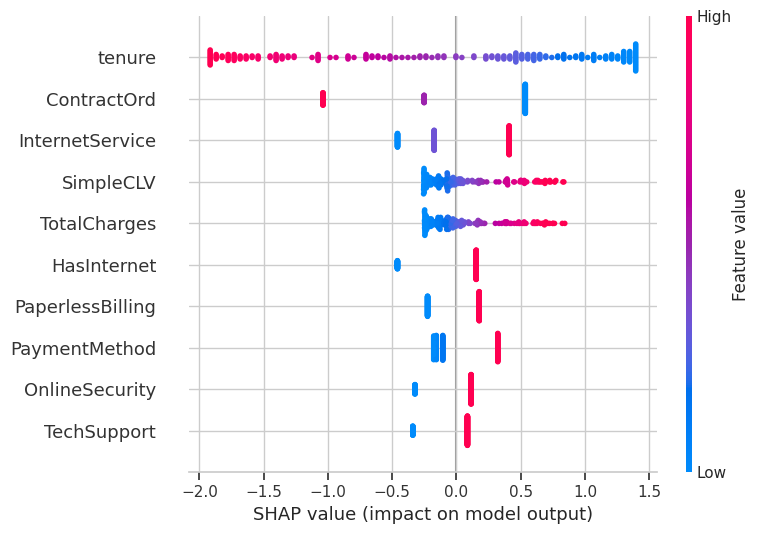

SHAP summary saved as shap_summary_top10.png


In [16]:
print("\n SHAP Global Explanation")

explainer = shap.Explainer(best_model, X_test_proc)
shap_values = explainer(X_test_proc[:200])

all_cols = num_cols + cat_cols
feature_names_map = {f"Feature {i}": col for i, col in enumerate(all_cols)}

shap_plot_df = pd.DataFrame(shap_values.values, columns=all_cols)

shap.summary_plot(shap_values.values, X_test_proc[:200], feature_names=all_cols, max_display=10, show=True)
plt.savefig("shap_summary_top10.png", bbox_inches='tight')
plt.close()
print("SHAP summary saved as shap_summary_top10.png")

Block 11 — User Input + Prediction + Counterfactuals (Enhanced)


Predicted Churn Probability for Sample User: 0.016 → Stay

 Counterfactual Interventions:
If Switch to Month-to-Month: churn prob 0.067 (Δ +0.051)
If Disable Auto-Pay (Electronic Check): churn prob 0.023 (Δ +0.008)
If Increase Monthly Charges by $20: churn prob 0.018 (Δ +0.003)
If Remove Online Security Service: churn prob 0.023 (Δ +0.008)
If Decrease Tenure by 60 months: churn prob 0.143 (Δ +0.128)


/tmp/ipython-input-49744292.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ChurnProbability', y='Intervention', data=intervention_df, palette='viridis')


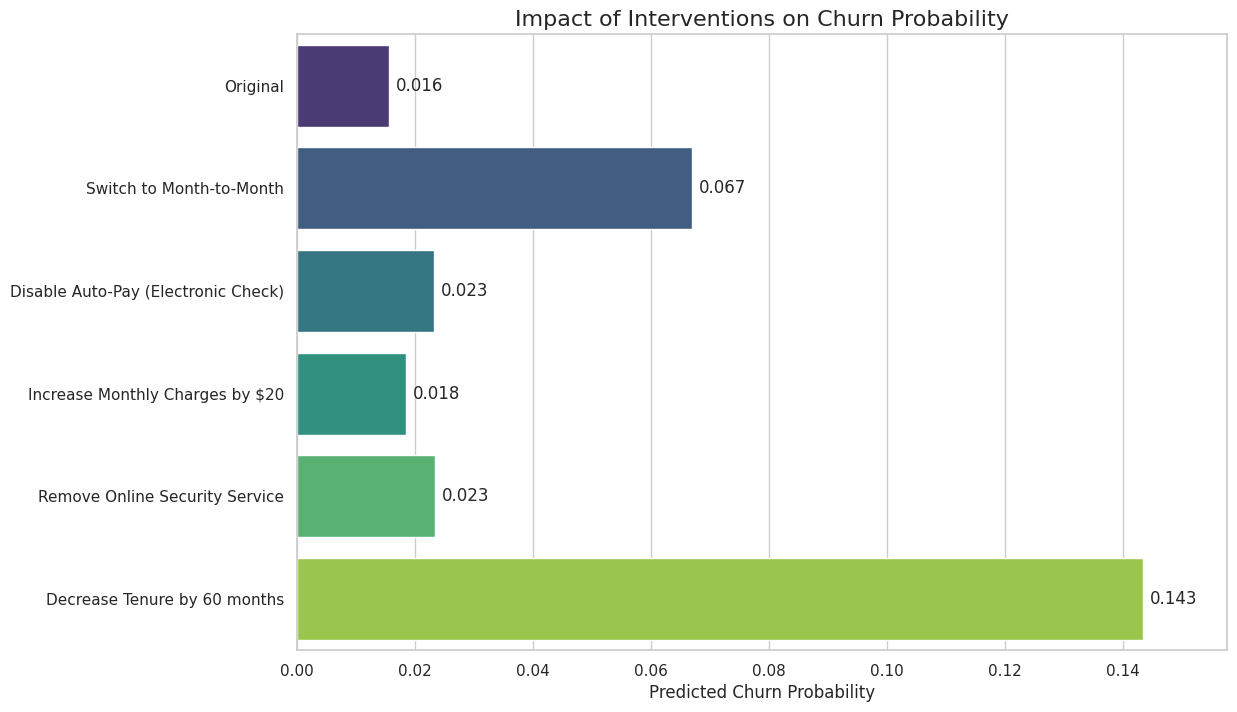



 SHAP Local Explanation (Why did the model predict 'Stay'?)


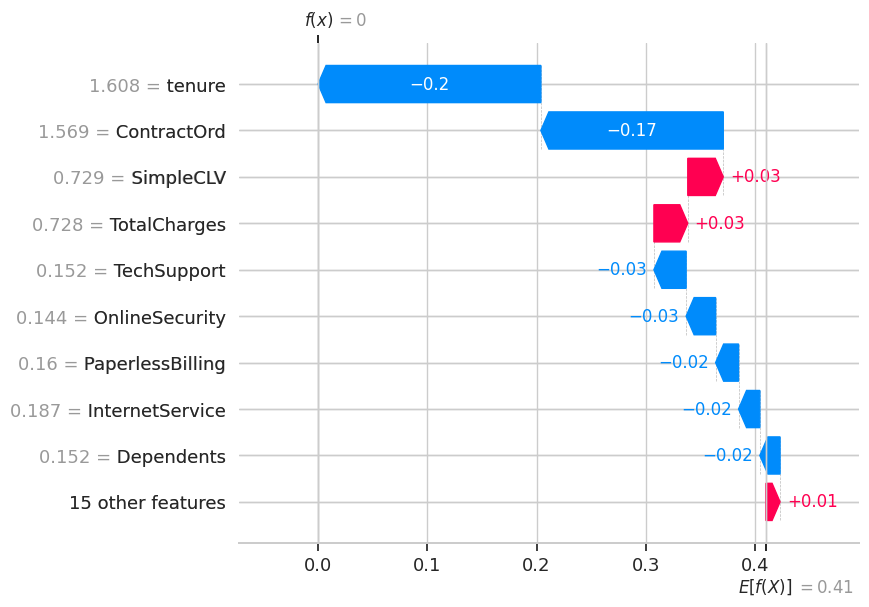

In [17]:
sample_user = {
    "gender": "Male",
    "SeniorCitizen": "No",
    "Partner": "Yes",
    "Dependents": "Yes",
    "tenure": 72,
    "PhoneService": "Yes",
    "MultipleLines": "Yes",
    "InternetService": "DSL",
    "OnlineSecurity": "Yes",
    "OnlineBackup": "Yes",
    "DeviceProtection": "Yes",
    "TechSupport": "Yes",
    "StreamingTV": "Yes",
    "StreamingMovies": "Yes",
    "Contract": "Two year",
    "PaperlessBilling": "No",
    "PaymentMethod": "Bank transfer (automatic)",
    "MonthlyCharges": 55.0,
    "TotalCharges": 3960.0
}

user_df = pd.DataFrame([sample_user])
user_df = add_features(user_df)

for c in X.columns:
    if c not in user_df.columns:
        user_df[c] = np.nan
user_df = user_df[X.columns]

user_num = num_imputer.transform(user_df[num_cols])
user_num = num_scaler.transform(user_num)
user_cat = target_encoder.transform(user_df[cat_cols])
user_proc = np.hstack([user_num, user_cat])

# Predict churn
proba = best_model.predict_proba(user_proc)[0,1]
label = "Churn" if proba >= 0.5 else "Stay"
print(f"Predicted Churn Probability for Sample User: {proba:.3f} → {label}")

# Counterfactual Interventions
print("\n Counterfactual Interventions:")
interventions = [
    ("Switch to Month-to-Month", {"Contract": "Month-to-month"}),
    ("Disable Auto-Pay (Electronic Check)", {"PaymentMethod": "Electronic check"}),
    ("Increase Monthly Charges by $20", {"MonthlyCharges": sample_user['MonthlyCharges'] + 20}),
    ("Remove Online Security Service", {"OnlineSecurity": "No"}),
    ("Decrease Tenure by 60 months", {"tenure": sample_user['tenure'] - 60})
]
intervention_results = {"Original": proba}
for desc, changes in interventions:
    new_input = sample_user.copy()
    new_input.update(changes)
    new_df = pd.DataFrame([new_input])
    new_df = add_features(new_df)
    for c in X.columns:
        if c not in new_df.columns: new_df[c] = np.nan
    new_df = new_df[X.columns]
    new_num = num_imputer.transform(new_df[num_cols])
    new_num = num_scaler.transform(new_num)
    new_cat = target_encoder.transform(new_df[cat_cols])
    new_proc = np.hstack([new_num, new_cat])
    new_proba = best_model.predict_proba(new_proc)[0,1]
    delta = new_proba - proba
    intervention_results[desc] = new_proba
    print(f"If {desc}: churn prob {new_proba:.3f} (Δ {delta:+.3f})")

plt.figure(figsize=(12, 8))
intervention_df = pd.DataFrame(list(intervention_results.items()), columns=['Intervention', 'ChurnProbability'])
ax = sns.barplot(x='ChurnProbability', y='Intervention', data=intervention_df, palette='viridis')
plt.title('Impact of Interventions on Churn Probability', fontsize=16)
plt.xlabel('Predicted Churn Probability', fontsize=12)
plt.ylabel('')
plt.xlim(0, max(intervention_df['ChurnProbability']) * 1.1)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                ha = 'left', va = 'center', xytext = (5, 0), textcoords = 'offset points')
plt.show()

print("\n\n SHAP Local Explanation (Why did the model predict 'Stay'?)")
explainer = shap.Explainer(best_model.predict, X_test_proc)
shap_values = explainer(user_proc)

shap_explanation = shap.Explanation(
    values=shap_values.values[0],
    base_values=shap_values.base_values[0],
    data=user_proc[0],
    feature_names=all_cols
)

shap.plots.waterfall(shap_explanation, max_display=10)

Block 12 — Save Model Artifacts


In [20]:
import joblib

joblib.dump(best_model, 'churn_model.pkl')
joblib.dump(num_imputer, 'num_imputer.pkl')
joblib.dump(num_scaler, 'num_scaler.pkl')
joblib.dump(target_encoder, 'target_encoder.pkl')

joblib.dump(num_cols, 'num_cols.pkl')
joblib.dump(cat_cols, 'cat_cols.pkl')

['cat_cols.pkl']